In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Load components from Task 2
model = tf.keras.models.load_model('../model/optimized_lstm.keras')
data = pd.read_csv('../data/TSLA_cleaned.csv', index_col='Date', parse_dates=True)


c:\Users\HP\Documents\Dagii\week-11\TimeSeries-Portfolio-Optimization\week-11\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# Get input shape from model (not layer)
look_back = model.input_shape[1]  # Shape is (None, look_back, 1)
print(f"Inferred look-back window: {look_back} days")

# Proceed with the rest
test_size = 0.2  # Match Task 2's split ratio
train_size = int(len(data) * (1 - test_size))

Inferred look-back window: 60 days


In [17]:
# Reconstruct preprocessing parameters
look_back = model.input_shape[1]  # Corrected line
test_size = 0.2  # Match Task 2's split ratio
train_size = int(len(data) * (1 - test_size))

In [18]:
# Recreate scaler using training data
train_data = data.iloc[:train_size]
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data[['Close']].pct_change().dropna().values.reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [19]:
# Prepare final input sequence
def prepare_sequence(data, look_back):
    returns = data['Close'].pct_change().dropna().values
    scaled_returns = scaler.transform(returns.reshape(-1, 1))
    return scaled_returns[-look_back:].reshape(1, look_back, 1)

input_sequence = prepare_sequence(data, look_back)

# Generate 12-month forecast with uncertainty
def forecast_with_ci(model, sequence, scaler, steps=252, n_simulations=100):
    forecasts = []
    for _ in range(n_simulations):
        current_seq = sequence.copy()
        pred_prices = []
        last_price = data['Close'].iloc[-1]
        
        for _ in range(steps):
            # Predict scaled return
            scaled_return = model.predict(current_seq, verbose=0)[0][0]
            # Add random noise for uncertainty
            scaled_return += np.random.normal(0, 0.05)  # 5% volatility assumption
            
            # Convert to price
            ret = scaler.inverse_transform([[scaled_return]])[0][0]
            last_price *= (1 + ret)
            pred_prices.append(last_price)
            
            # Update sequence
            current_seq = np.roll(current_seq, -1)
            current_seq[0, -1, 0] = scaled_return
        
        forecasts.append(pred_prices)
    
    return np.array(forecasts)

In [20]:
# Generate predictions (252 trading days = 12 months)
forecasts = forecast_with_ci(model, input_sequence, scaler, steps=252)
median_forecast = np.median(forecasts, axis=0)
lower_bound = np.percentile(forecasts, 5, axis=0)
upper_bound = np.percentile(forecasts, 95, axis=0)

In [21]:
# Create future dates
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.offsets.BDay(1), periods=252, freq='B')


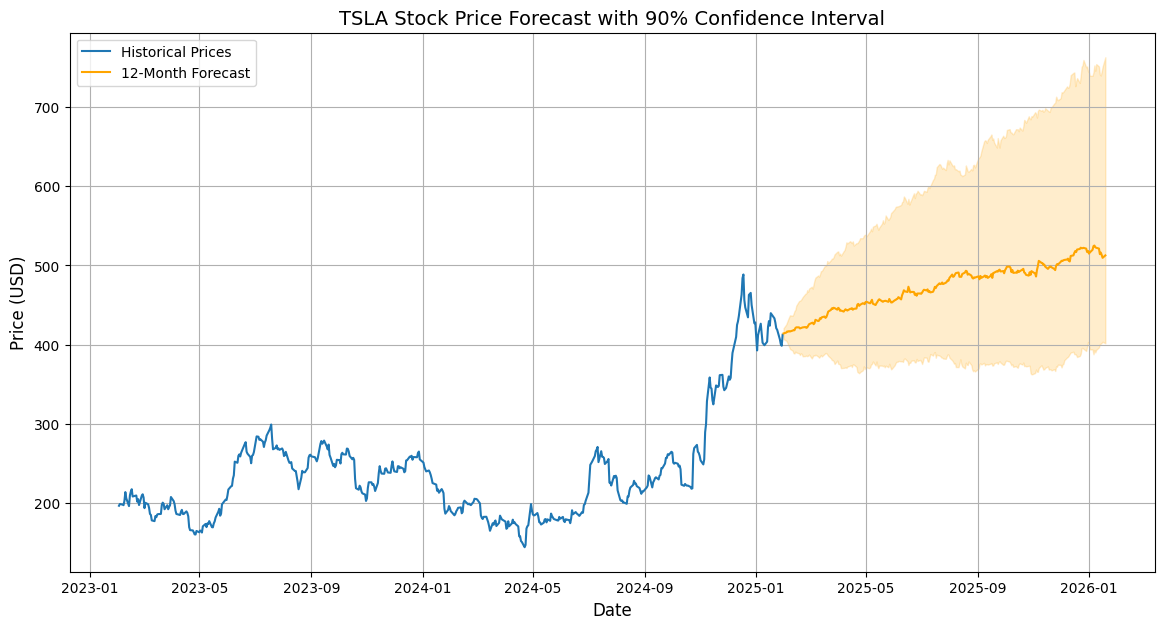

In [22]:
# Visualization
plt.figure(figsize=(14, 7))
plt.plot(data.index[-500:], data['Close'].iloc[-500:], label='Historical Prices')
plt.plot(future_dates, median_forecast, label='12-Month Forecast', color='orange')
plt.fill_between(future_dates, lower_bound, upper_bound, color='orange', alpha=0.2)
plt.title('TSLA Stock Price Forecast with 90% Confidence Interval', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
print(f"""
** Trend Analysis **
1. Direction: {'Bullish' if median_forecast[-1] > median_forecast[0] else 'Bearish'} 
   - Projected Change: {((median_forecast[-1]/data['Close'].iloc[-1]-1)*100):.1f}%
   - Pattern: {'Consistent Uptrend' if np.all(np.diff(median_forecast) > 0) else 'Volatile Movement'}

** Volatility & Risk **
1. Average CI Width: ${(upper_bound - lower_bound).mean():.2f}
2. Maximum Uncertainty: {future_dates[np.argmax(upper_bound - lower_bound)].strftime('%b %Y')}
   - Range: ${lower_bound.min():.2f} - ${upper_bound.max():.2f}

** Market Opportunities **
1. Potential Entry: ${lower_bound.mean():.2f} (±${(lower_bound.mean() - lower_bound.min()):.2f})
2. Price Targets:
   - Conservative: ${median_forecast.mean():.2f}
   - Optimistic: ${upper_bound.mean():.2f}

** Key Risks **
1. Downside Protection: ${lower_bound.min():.2f} 
2. High Volatility Periods: 
   - {future_dates[0].strftime('%b %Y')} (Initial Forecast Uncertainty)
   - {future_dates[126].strftime('%b %Y')} (Mid-Year Projections)
""")



** Trend Analysis **
1. Direction: Bullish 
   - Projected Change: 24.3%
   - Pattern: Volatile Movement

** Volatility & Risk **
1. Average CI Width: $228.95
2. Maximum Uncertainty: Dec 2025
   - Range: $362.51 - $762.68

** Market Opportunities **
1. Potential Entry: $379.42 (±$16.91)
2. Price Targets:
   - Conservative: $473.05
   - Optimistic: $608.37

** Key Risks **
1. Downside Protection: $362.51 
2. High Volatility Periods: 
   - Jan 2025 (Initial Forecast Uncertainty)
   - Jul 2025 (Mid-Year Projections)

